<a href="https://colab.research.google.com/github/ysurs/nn_with_karpathy/blob/main/batchnorm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('/content/drive/MyDrive/building_makemore/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)*(5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g)*0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g)* 0.01
b2 = torch.randn(vocab_size,                      generator=g)*0.0


parameters = [C, W1,b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [11]:
hpreact.mean(0,keepdims=True).shape

torch.Size([1, 200])

In [6]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  #print(Yb)
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 + b1 
  hpreact=(hpreact-hpreact.mean(0,keepdims=True))/(hpreact.std(0,keepdims=True))
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:2d}/{max_steps:2d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  #break

 0/200000: 3.3179
10000/200000: 2.1910
20000/200000: 2.3270
30000/200000: 2.5396
40000/200000: 1.9468
50000/200000: 2.3331
60000/200000: 2.3852
70000/200000: 2.1173
80000/200000: 2.3159
90000/200000: 2.2010
100000/200000: 1.8591
110000/200000: 2.0881
120000/200000: 1.9389
130000/200000: 2.3913
140000/200000: 2.0949
150000/200000: 2.1458
160000/200000: 1.7824
170000/200000: 1.7249
180000/200000: 1.9752
190000/200000: 1.8614


### As we can see, the loss on initialisation is very high and subsequent losses are no where near that value. This shouldn't be the case ideally. On initialisation, every character should have equally likely chance of getting picked up but this high loss value indicates that some characters are more probable of getting picked up than others.

### Ideally the probabilities will be equally likely and equal to 1/27

In [26]:
## The ideal loss on initialisation should be 

(-torch.tensor(1/27).log())

tensor(3.2958)

In [34]:
# A four dimensional example. Assuming the target label is 2
logits=torch.tensor([0.0,0.0,0.0,0.0,0.0])
probs=torch.softmax(logits,dim=0)
loss=-probs[2].log()
probs,loss

(tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000]), tensor(1.6094))

### If we change numbers from 0, we will get more loss and if we keep every number close to 0, we will get less loss

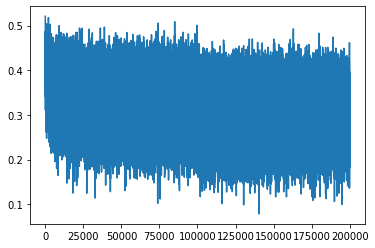

In [7]:
plt.plot(lossi)

In [8]:
@torch.no_grad() # this decorator disables gradient tracking for efficiency reasons
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  h = torch.tanh(embcat@W1+b1) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


loss log
original:
train 2.1245384216308594 val 2.1750576496124268

fix softmax confidently wrong:
train 2.07 val 2.13 (we achieved this by fixing our initialisation loss which we achieved by setting b2 to 0 and reducing W2 values) We did this because, at initialisation, we were getting a very high loss value. Getting high loss is not possible because during initialisation, every character is equally probable and the neural network does favour any particular character.

fix tanh layer too saturated at init: train 2.0355966091156006 val 2.1026785373687744 :We scaled down value of hpreact. This was done because h which we obtain after passing preact to tanh was producing a lot of -1 and 1 values. This can kill gradients.

using kaiming init formula for initialisation: we get train 2.0376641750335693
val 2.106989622116089. Motivation is that we want to have similar gaussian distribution throughout the network and it should happen that after some operations, distribution is changing


In [12]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      h = torch.tanh(emb.view(1, -1)@W1+b1) # concatenate the vectors
      logits=h@W2+b2
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

carlah.
amille.
khy.
myli.
taty.
skanden.
jazonen.
amerynchireei.
nellara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wanthoniearyn.
kai.
everusabee.
demiia.
